In [1]:
from aemulusnu_massfunction.massfunction_fitting_tinker import *
from aemulusnu_mf_lib.utils import *


In [2]:
fiducial_cosmology = {'10^9 As':2.1,
                      'ns': 0.9649,
                      'H0': 67.36,
                      'w0': -1,
                      'ombh2': 0.02237,
                      'omch2': 0.12,
                      'nu_mass_ev': 0.06,}

key_ordering = ['10^9 As', 'ns', 'H0', 'w0', 'ombh2', 'omch2', 'nu_mass_ev']
def get_cosmo_vals(cosmology):
    return [cosmology[curr_key] for curr_key in key_ordering]
def get_cosmo_dict(cosmo_vals):
    return dict(zip(key_ordering, cosmo_vals))

def get_ccl_cosmology(cosmo_vals):
    cosmology = get_cosmo_dict(cosmo_vals)

    h = cosmology['H0']/100
    Ωb =  cosmology['ombh2'] / h**2
    Ωc =  cosmology['omch2'] / h**2

    cosmo = ccl.Cosmology(Omega_c=Ωc,
                          Omega_b=Ωb,
                          h=h,
                          A_s=cosmology['10^9 As']*10**(-9),
                          n_s=cosmology['ns'],
                          w0=cosmology['w0'],
                          m_nu=[cosmology['nu_mass_ev']/3, cosmology['nu_mass_ev']/3, cosmology['nu_mass_ev']/3])

    return cosmo

In [3]:
import numpy as np
from scipy.interpolate import interp1d

from pyccl.halos import MassFunc, get_delta_c


class CUSTOM_MassFuncTinker10(MassFunc):
    """Implements the mass function of `Tinker et al. 2010
    <https://arxiv.org/abs/1001.3162>`_. This parametrization accepts S.O.
    masses with :math:`200 < \\Delta < 3200`, defined with respect to the
    matter density. This can be automatically translated to S.O. masses
    defined with respect to the critical density.

    Args:
        mass_def (:class:`~pyccl.halos.massdef.MassDef` or :obj:`str`):
            a mass definition object, or a name string.
        mass_def_strict (:obj:`bool`): if ``False``, consistency of the mass
            definition will be ignored.
        norm_all_z (:obj:`bool`): if ``True``, the mass function will be
            normalised to yield the total matter density when integrated
            over mass at all redshifts (as opposed to :math:`z=0` only).
    """
    __repr_attrs__ = __eq_attrs__ = ("mass_def", "mass_def_strict",
                                     "norm_all_z",)
    name = 'custom Tinker10'
    mirror_cosmos = {}
    
    def __init__(self, *,
                 mass_def="200m",
                 mass_def_strict=True,
                 norm_all_z=False):
        self.norm_all_z = norm_all_z
        super().__init__(mass_def=mass_def, mass_def_strict=mass_def_strict)

    def _get_logM_sigM(self, cosmo, M, a, *, return_dlns=False):
        """Compute ``logM``, ``sigM``, and (optionally) ``dlns_dlogM``.
            Using Costanzi et al. 2013 (JCAP12(2013)012) perscription
            to evaluate HMF in nuCDM cosmology, we replace P_m with P_cb
            """
        print('custom sigm')
        self.mirror_cosmos[cosmo].compute_sigma()  # initialize sigma(M) splines if needed
        logM = np.log10(M)
        # sigma(M)
        status = 0
        sigM, status = lib.sigM_vec(self.mirror_cosmos[cosmo].cosmo, a, logM, len(logM), status)
        check(status, cosmo=self.mirror_cosmos[cosmo])
        if not return_dlns:
            return logM, sigM

        # dlogsigma(M)/dlog10(M)
        dlns_dlogM, status = lib.dlnsigM_dlogM_vec(self.mirror_cosmos[cosmo].cosmo, a, logM,
                                                   len(logM), status)
        check(status, cosmo=self.mirror_cosmos[cosmo])
        return logM, sigM, dlns_dlogM
        
    def __call__(self, cosmo, M, a):
        """ Returns the mass function for input parameters. 
            Using Costanzi et al. 2013 (JCAP12(2013)012) perscription
            to evaluate HMF in nuCDM cosmology

        Args:
            cosmo (:class:`~pyccl.cosmology.Cosmology`): A Cosmology object.
            M (:obj:`float` or `array`): halo mass.
            a (:obj:`float`): scale factor.

        Returns:
            (:obj:`float` or `array`): mass function \
                :math:`dn/d\\log_{10}M` in units of Mpc^-3 (comoving).
        """
        if(cosmo not in self.mirror_cosmos):
            self.mirror_cosmos[cosmo] = ccl.Cosmology(Omega_c=cosmo['Omega_c'],
                                                 Omega_b=cosmo['Omega_b'],
                                                 h=cosmo['h'],
                                                 A_s=cosmo['A_s'],
                                                 n_s=cosmo['n_s'],
                                                 w0=cosmo['w0'],
                                                 m_nu=cosmo['m_nu'])
            funcType = type(self.mirror_cosmos[cosmo]._compute_linear_power)

            self.mirror_cosmos[cosmo]._compute_linear_power = MethodType(custom_compute_linear_power, self.mirror_cosmos[cosmo])
            
        M_use = np.atleast_1d(M)
        logM, sigM, dlns_dlogM = self._get_logM_sigM( 
            cosmo, M_use, a, return_dlns=True)
        print('custom rho')

        rho = (const.RHO_CRITICAL
               * (cosmo['Omega_c'] + cosmo['Omega_b'])
               * cosmo['h']**2)

        f = self._get_fsigma(cosmo, sigM, a, 2.302585092994046 * logM)
        mf = f * rho * dlns_dlogM / M_use
        if np.ndim(M) == 0:
            return mf[0]
        return mf
    
 
    def _check_mass_def_strict(self, mass_def):
        return mass_def.Delta == "fof"

    def _setup(self):
        delta = np.array(
            [200., 300., 400., 600., 800., 1200., 1600., 2400., 3200.])
        alpha = np.array(
            [0.368, 0.363, 0.385, 0.389, 0.393, 0.365, 0.379, 0.355, 0.327])
        beta = np.array(
            [0.589, 0.585, 0.544, 0.543, 0.564, 0.623, 0.637, 0.673, 0.702])
        gamma = np.array(
            [0.864, 0.922, 0.987, 1.09, 1.20, 1.34, 1.50, 1.68, 1.81])
        phi = np.array(
            [-0.729, -0.789, -0.910, -1.05, -1.20, -1.26, -1.45, -1.50, -1.49])
        eta = np.array(
            [-0.243, -0.261, -0.261, -0.273,
             -0.278, -0.301, -0.301, -0.319, -0.336])

        ldelta = np.log10(delta)
        self.pA0 = interp1d(ldelta, alpha)
        self.pa0 = interp1d(ldelta, eta)
        self.pb0 = interp1d(ldelta, beta)
        self.pc0 = interp1d(ldelta, gamma)
        self.pd0 = interp1d(ldelta, phi)
        if self.norm_all_z:
            p = np.array(
                [-0.158, -0.195, -0.213, -0.254, -0.281,
                 -0.349, -0.367, -0.435, -0.504])
            q = np.array(
                [0.0128, 0.0128, 0.0143, 0.0154, 0.0172,
                 0.0174, 0.0199, 0.0203, 0.0205])
            self.pp0 = interp1d(ldelta, p)
            self.pq0 = interp1d(ldelta, q)

    def _get_fsigma(self, cosmo, sigM, a, lnM):
        ld = np.log10(self.mass_def._get_Delta_m(cosmo, a))
        nu = get_delta_c(cosmo, a, 'EdS_approx') / sigM
        # redshift evolution only up to z=3
        a = np.clip(a, 0.25, 1)
        pa = self.pa0(ld) * a**(-0.27)
        pb = self.pb0(ld) * a**(-0.20)
        pc = self.pc0(ld) * a**0.01
        pd = self.pd0(ld) * a**0.08
        pA0 = self.pA0(ld)
        if self.norm_all_z:
            z = 1/a - 1
            pp = self.pp0(ld)
            pq = self.pq0(ld)
            pA0 *= np.exp(z * (pp + pq * z))
        return nu * pA0 * (1 + (pb * nu)**(-2 * pd)) * (
            nu**(2 * pa) * np.exp(-0.5 * pc * nu**2))

In [4]:
fiducial_cosmo_vals = get_cosmo_vals(fiducial_cosmology)
fiducial_ccl_cosmo = get_ccl_cosmology(tuple(fiducial_cosmo_vals))



In [5]:
import numpy as np
from matplotlib import pyplot as plt
import pyccl as ccl
import logging

In [6]:
# Cosmology
cosmo = fiducial_ccl_cosmo
h = cosmo['h']
# Array of masses
M = 10**np.linspace(11, 16, 150)

# Array of redshifts
z_arr = np.linspace(0.,1.,16)

In [7]:
hmfs = []
# Tinker 2010 mass function
hmfs.append(ccl.halos.MassFuncTinker10(mass_def='200m'))
hmfs.append(CUSTOM_MassFuncTinker10(mass_def='200m'))

custom sigm
custom rho


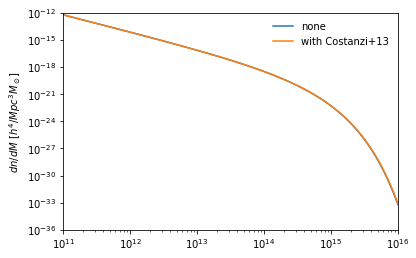

In [8]:
plt.figure()



nm = hmfs[0](cosmo, M, 1/(1+0.8))
plt.plot(M, nm/(h**3 * M * np.log(10)),label='none')


nm_Costanzi13 = hmfs[1](cosmo, M, 1/(1+0.8))
plt.plot(M, nm_Costanzi13/(h**3 * M * np.log(10)), label='with Costanzi+13')



plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-36, 1e-12)
plt.xlim(1e11, 1e16)
plt.ylabel('$dn/dM\ [h^4/ Mpc^3 M_\odot]$')
plt.legend(frameon=False)
plt.show()

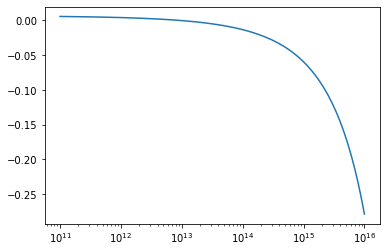

In [9]:
plt.plot(M, (nm-nm_Costanzi13)/nm)
plt.xscale('log')

In [10]:
%%time 
print(1)

1
CPU times: user 37 µs, sys: 6 µs, total: 43 µs
Wall time: 37 µs


In [11]:
class oldMassFuncAemulusNu_fitting_all_snapshot(MassFunc):
    """
    """
    name = 'AemulusNu'

    def __init__(self, *,
                 mass_def="200m",
                 mass_def_strict=True):
        super().__init__(mass_def=mass_def, mass_def_strict=mass_def_strict)

    def _check_mass_def_strict(self, mass_def):
        return mass_def.Delta == "200m"

    def _setup(self):
        self.params = {'d0':-1, 'd1':-1,
                       'e0':-1, 'e1':-1,
                       'f0':-1, 'f1':-1,
                       'g0':-1, 'g1':-1}

    def set_params(self, params):
        self.params = dict(zip(self.params.keys(), params))
        self.paired_params = list(zip(params, params[1:]))[::2]

    def _get_fsigma(self, cosmo, sigM, a, lnM):
        scale_params = dict(zip(['d','e','f','g'],[p(p0, p1, a) for p0, p1 in self.paired_params]))
        return f_G(a, np.exp(lnM), sigM, **scale_params)


In [12]:
mf_new = MassFuncAemulusNu_fitting_all_snapshot()
mf_old = oldMassFuncAemulusNu_fitting_all_snapshot()

In [23]:
%%time
for i in range(10000):
    params = (np.random.random(8)+1)/10+1
    mf_new.set_params(params)
    mf_new(cosmo, M, 1/(1+0.8))
    


CPU times: user 1.06 s, sys: 17.1 ms, total: 1.08 s
Wall time: 1.05 s


In [24]:
%%time
for i in range(10000):
    params = (np.random.random(8)+1)/10+1
    mf_old.set_params(params)
    mf_old(cosmo, M, 1/(1+0.8))
    
#1s 1s 1s

CPU times: user 1.03 s, sys: 22.9 ms, total: 1.05 s
Wall time: 1.02 s


In [15]:
import cProfile
cProfile.run('mf_old(cosmo, M, 1/(1+0.8))')

         43 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 2371847337.py:24(_get_fsigma)
        1    0.000    0.000    0.000    0.000 2371847337.py:25(<listcomp>)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 ccllib.py:1390(sigM_vec)
        1    0.000    0.000    0.000    0.000 ccllib.py:1399(dlnsigM_dlogM_vec)
        2    0.000    0.000    0.000    0.000 cosmology.py:495(__getitem__)
        1    0.000    0.000    0.000    0.000 cosmology.py:642(compute_sigma)
        1    0.000    0.000    0.000    0.000 cosmology.py:710(has_sigma)
        2    0.000    0.000    0.000    0.000 cosmology_params.py:10(__getattribute__)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:1976(_shape_dispatcher)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:1980(shape)
        1  

In [16]:
import cProfile
cProfile.run('mf_new(cosmo, M, 1/(1+0.8))')

         50 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 ccllib.py:1390(sigM_vec)
        1    0.000    0.000    0.000    0.000 ccllib.py:1399(dlnsigM_dlogM_vec)
        6    0.000    0.000    0.000    0.000 cosmology.py:495(__getitem__)
        1    0.000    0.000    0.000    0.000 cosmology.py:642(compute_sigma)
        1    0.000    0.000    0.000    0.000 cosmology.py:710(has_sigma)
        3    0.000    0.000    0.000    0.000 cosmology_params.py:10(__getattribute__)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:1976(_shape_dispatcher)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:1980(shape)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:3172(_ndim_dispatcher)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:3176(ndim)
      

In [17]:
from pyccl._core.caching import _to_hashable, hash_


In [18]:
tup = _to_hashable(cosmo["extra_parameters"])

In [ ]:
#          1823 function calls (1469 primitive calls) in 0.001 seconds

#    Ordered by: standard name

#    ncalls  tottime  percall  cumtime  percall filename:lineno(function)
#         1    0.000    0.000    0.001    0.001 <string>:1(<module>)
#    366/18    0.000    0.000    0.000    0.000 caching.py:12(_to_hashable)
#        18    0.000    0.000    0.000    0.000 caching.py:29(<dictcomp>)
#         6    0.000    0.000    0.000    0.000 caching.py:37(<listcomp>)
#         6    0.000    0.000    0.000    0.000 caching.py:49(hash_)
#         1    0.000    0.000    0.000    0.000 ccllib.py:1390(sigM_vec)
#         1    0.000    0.000    0.000    0.000 ccllib.py:1399(dlnsigM_dlogM_vec)
#         3    0.000    0.000    0.000    0.000 cosmology.py:495(__getitem__)
#         1    0.000    0.000    0.000    0.000 cosmology.py:642(compute_sigma)
#         1    0.000    0.000    0.000    0.000 cosmology.py:710(has_sigma)
#         3    0.000    0.000    0.000    0.000 cosmology_params.py:10(__getattribute__)
#         2    0.000    0.000    0.000    0.000 fromnumeric.py:1976(_shape_dispatcher)
#         2    0.000    0.000    0.000    0.000 fromnumeric.py:1980(shape)
#         6    0.000    0.000    0.000    0.000 fromnumeric.py:2416(_all_dispatcher)
#         6    0.000    0.000    0.000    0.000 fromnumeric.py:2421(all)
#         1    0.000    0.000    0.000    0.000 fromnumeric.py:3172(_ndim_dispatcher)
#         1    0.000    0.000    0.000    0.000 fromnumeric.py:3176(ndim)
#         6    0.000    0.000    0.000    0.000 fromnumeric.py:71(_wrapreduction)
#         6    0.000    0.000    0.000    0.000 fromnumeric.py:72(<dictcomp>)
#       252    0.000    0.000    0.000    0.000 inspect.py:2552(default)
#        12    0.000    0.000    0.000    0.000 inspect.py:2865(parameters)
#         1    0.000    0.000    0.000    0.000 massfunction.py:10(f_G)
#         4    0.000    0.000    0.000    0.000 massfunction.py:17(p)
#         1    0.000    0.000    0.000    0.000 massfunction.py:4(B)
#         1    0.000    0.000    0.000    0.000 massfunction_fitting_tinker.py:114(_get_fsigma)
#         1    0.000    0.000    0.000    0.000 massfunction_fitting_tinker.py:115(<listcomp>)
#         1    0.000    0.000    0.001    0.001 massfunction_fitting_tinker.py:49(_get_logM_sigM)
#         1    0.000    0.000    0.001    0.001 massfunction_fitting_tinker.py:69(__call__)
#         4    0.000    0.000    0.000    0.000 parameters_base.py:63(__getattribute__)
#         2    0.000    0.000    0.000    0.000 pyutils.py:66(check)
#         6    0.000    0.000    0.001    0.000 repr_.py:103(build_string_Cosmology)
#       126    0.000    0.000    0.000    0.000 repr_.py:133(test_eq)
#        12    0.000    0.000    0.001    0.000 repr_.py:140(printdict)
#        12    0.000    0.000    0.000    0.000 repr_.py:144(<dictcomp>)
#        12    0.000    0.000    0.000    0.000 repr_.py:145(<dictcomp>)
#        48    0.000    0.000    0.000    0.000 repr_.py:150(<genexpr>)
#         6    0.000    0.000    0.000    0.000 repr_.py:157(printextras)
#         6    0.000    0.000    0.000    0.000 repr_.py:168(metadata)
#         6    0.000    0.000    0.001    0.000 schema.py:280(__hash__)
#         1    0.000    0.000    0.000    0.000 shape_base.py:19(_atleast_1d_dispatcher)
#         1    0.000    0.000    0.000    0.000 shape_base.py:23(atleast_1d)
#         1    0.000    0.000    0.001    0.001 {built-in method builtins.exec}
#         9    0.000    0.000    0.000    0.000 {built-in method builtins.getattr}
#       108    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
#        12    0.000    0.000    0.000    0.000 {built-in method builtins.hash}
#         6    0.000    0.000    0.000    0.000 {built-in method builtins.hex}
#       432    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
#        45    0.000    0.000    0.000    0.000 {built-in method builtins.len}
#         6    0.000    0.000    0.000    0.000 {built-in method builtins.max}
#      12/6    0.000    0.000    0.001    0.000 {built-in method builtins.repr}
#        18    0.000    0.000    0.000    0.000 {built-in method builtins.sorted}
#         1    0.000    0.000    0.000    0.000 {built-in method numpy.asanyarray}
#         1    0.000    0.000    0.000    0.000 {built-in method pyccl._ccllib.dlnsigM_dlogM_vec}
#         1    0.000    0.000    0.000    0.000 {built-in method pyccl._ccllib.sigM_vec}
#         1    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
#         1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
#       126    0.000    0.000    0.000    0.000 {method 'get' of 'dict' objects}
#        60    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
#        12    0.000    0.000    0.000    0.000 {method 'items' of 'mappingproxy' objects}
#        12    0.000    0.000    0.000    0.000 {method 'pop' of 'dict' objects}
#         6    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}